In [344]:
from algoaux import *
from lib import *
from dataShaper import *
from models import cnn
from graphs import *
import re
import os
import traceback
sns.set_theme(style="whitegrid")
csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

In [345]:
def populateDataLog(input_dir):
    dataLog={}
    for file in os.listdir(input_dir):
        if file != ".DS_Store":
            lossArray = []
            gapArray = []
            localGapArray =[]
            a=open(input_dir+file, "r").read().replace("0>", "").split("\n")
            for item in a:
                try:
                    b=item.strip().replace(":", "").split()
                    loss, gap, local_gap = b[2],b[4], b[-1]
                    lossArray.append(loss)
                    gapArray.append(gap)
                    localGapArray.append(local_gap)
                except:
                    pass
            dataLog[file]={
                "lossArray" :lossArray,
                "gapArray" : gapArray,
                "localGapArray" : localGapArray
            }
    return dataLog

def read_result_from_txt(path):
    files = os.listdir(path)
    #data_file = [file
    dataLog = {}
    for file in os.listdir(path):
        if file != ".DS_Store":
            with open(path+file,'r') as f:
                lines = f.readlines()
            result = [line for line in lines if line.startswith("t_")]
            losses = np.zeros(len(result))
            gap = np.zeros(len(result))
            for k,v in enumerate(result):
                modified = re.split('[\n : ]',v)
                #print(modified[4])
                losses[k] = float(modified[6])
                gap[k] = float(modified[10])
            dataLog[int(file.split("-")[1])] = {"losses":losses,
                      "gap":gap}
    return dataLog

def read_result_from_csv(path):
    dataLog = {}
    for file in os.listdir(path):
        if file != ".DS_Store":
            try:
                pd_file = pd.read_csv(os.path.join(path,file), index_col=0)
                dataLog[str(file.split("_")[1].split('.')[0])] = pd_file
                #dataLog[]
            except:
                print("Skipping unrelated file ...")
                pass
    return dataLog

In [346]:
def average_loss(array):
    nb_iter = len(array)
    onlineloss = np.cumsum(array)
    arangement = np.arange(1,nb_iter+1)
    onlineloss = onlineloss/arangement
    return onlineloss

In [347]:
def plotDeFW(floor, graph_type, feature, path_analysis, save_path, save=False ,metric="loss", average=False):
    
    path_dmfw = os.path.join(path_analysis,f'{graph_type}-{feature}/')
    path_defw = os.path.join(path_analysis,"Defw/"+f'{feature}/'+f'{graph_type}/')
    
    dmfw = read_result_from_txt(path_dmfw)
    defw = read_result_from_csv(path_defw)
    keys_defw = str(floor)
    keys_dmfw = int(floor)
    
    fig = plt.figure(figsize=(10,5))
    #plt.title(f"Floor{floor} - {graph_type} Graph", fontsize=14,**hfont)
    if metric=="loss":
        plt.plot(dmfw[keys_dmfw]["losses"][1:-1], label="DMFW",marker='o', markersize=3,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        if average:
            plt.plot(average_loss(dmfw[keys_dmfw]["losses"][1:-1]), label="DMFW Average",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
            
        plt.plot(defw[keys_defw]["Loss"][1:-1].values, label="DeFW",marker='^', markersize=3,
                 markevery=[i for i in range(504) if i%10==0],linewidth=1)
        if average:
            plt.plot(average_loss(defw[keys_defw]["Loss"][1:-1]), label="DeFW Average",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["losses"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Loss",**hfont)
        plt.xlabel("Iteration",**hfont)
        plt.yscale("log")
        if save:
            plt.savefig(save_path+f"Floor{floor}-{graph_type}-{feature}.png")
        plt.show()
        
    elif metric=="gap":
        plt.plot(dmfw[keys_dmfw]["gap"][1:-1], label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        plt.plot(defw[keys_defw]["Gap"][1:-1].values, label="DeFW",marker='^', markersize=5,
                 markevery=[i for i in range(504) if i%10==0],linewidth=1)
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["losses"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Gap",**hfont)
        plt.xlabel("Iteration",**hfont)
        plt.yscale("log")
        if save:
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            plt.savefig(save_path+f"Floor{floor}-{graph_type}-{feature}.png")
        plt.show()
    else:
        raise ValueError("Unrecognized metric")

In [348]:
def plotOFW(floor, graph_type, feature, path_dmfw, path_analysis, save_path, save=False ,metric="loss", average=False, indep_loss = False):
    #path_dmfw = os.path.join(path_analysis,f'new-{feature}/{graph_type}/alpha/')
    path_ofw = os.path.join(path_analysis,"Ofw/"+f'{feature}/')
    
    print(path_dmfw)
    
    #dmfw = read_result_from_txt(path_dmfw)
    dmfw = read_result_from_csv(path_dmfw)
    ofw = read_result_from_csv(path_ofw)
    
    #print(dmfw)

    
    real_value = [1,2,4,5]
    real_zone = []*len(real_value)
    
    keys_dmfw = str(floor)
    #print(keys_dmfw)
    keys_ofw = sorted([zone for zone in list(ofw.keys()) if zone.split("z")[0] == str(floor)])
    average_ofw = sum([ofw[zone] for zone in keys_ofw])/len(keys_ofw)
    
    print(f'Avg OFW {np.mean(average_ofw)}')
    print(f'Avg DMFW {np.mean(dmfw[keys_dmfw]["Loss"])}')
    
    
    for i in range(len(keys_ofw)):
        real_zone.append(real_value[i])
    
    fig = plt.figure(figsize=(10,5))
    if metric=="loss":
        if average==True:
            plt.plot(average_loss(dmfw[keys_dmfw]["Loss"][1:-1]), label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
            if indep_loss:
                for zone, real in zip(keys_ofw,real_zone):
                    plt.plot(average_loss(ofw[zone]["Loss"][1:-1].values), ls='--' ,label="OFW"+f' Zone {real}',marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=1)
            else:
                plt.plot(average_loss(average_ofw["Loss"][1:-1]),ls='--',label="OFW",marker='^', markersize=5,
                     markevery=[i for i in range(504) if i%10==0], linewidth=1)
                
        elif average=="Full":
            plt.plot(dmfw[keys_dmfw]["Loss"][1:-1], label="DMFW ",marker='o', markersize=3,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1,c="#8E94D6")
            plt.plot(average_loss(dmfw[keys_dmfw]["Loss"][1:-1]), label="DMFW Online Loss",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1.3, c="#8E94D6")
            plt.plot(average_ofw["Loss"][1:-1].values, ls='--',label="OFW",marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=1, c="#DFA063")
            plt.plot(average_loss(average_ofw["Loss"][1:-1]),ls='--',label="OFW Online Loss",marker='^', markersize=5,
                     markevery=[i for i in range(504) if i%10==0], linewidth=1.3, c="#DFA063")
        else:
            plt.plot(dmfw[keys_dmfw]["Loss"][1:-1], label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
            if indep_loss:
                for zone, real in zip(keys_ofw,real_zone):
                    plt.plot(ofw[zone]["Loss"][1:-1].values,ls = '--' ,label="OFW"+f' Zone {real}',marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=0.3)      
            else :
                plt.plot(average_ofw["Loss"][1:-1].values, ls='--',label="OFW",marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=1)    
            
                
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["Loss"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Loss",**hfont)
        
    if metric=="gap":
        plt.plot(dmfw[keys_dmfw]["Gap"][1:-1], label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        if indep_loss:
            for zone, real in zip(keys_ofw,real_zone):
                plt.plot(ofw[zone]["Gap"][1:-1].values,ls = '--' ,label="OFW"+f' Zone {real}',marker='^', markersize=3,
                         markevery=[i for i in range(504) if i%10==0],linewidth=0.3)      
        else :
            plt.plot(average_ofw["Gap"][1:-1].values, ls='--',label="OFW",marker='^', markersize=3,
                 markevery=[i for i in range(504) if i%10==0],linewidth=1)    
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["losses"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Gap",**hfont)  
        
    plt.xlabel("Iteration",**hfont)
    plt.yscale("log")
    if save:
        save_path_feat = save_path+f'{feature}/'
        if not os.path.exists(save_path_feat):
            os.makedirs(save_path_feat)
        plt.savefig(save_path_feat+f"Floor{floor}-{metric}-{graph_type}-{average}-{indep_loss}.png")
    plt.show()

In [349]:
def plotDMFW(path,path_to_save,metric,floor_idx, save=False):
    data = read_result_from_csv(path)
    key = [ele for ele in data.keys()][0]
    print(data)
    #print(np.mean(data[str(floor_idx)][metric][:-1]))
    plt.figure(figsize=(10,5))
    plt.plot(data[key][metric][1:-1],label="DMFW"+f' {metric}')#,marker='o', markersize=5,
                     #markevery=[i for i in range(504) if i%10==0], linewidth=1)
    if metric == "Loss":
        plt.plot(average_loss(data[key][metric][:-1]),ls='--',label="DMFW Online"+f' {metric}')#,marker='^', markersize=5,
                         #markevery=[i for i in range(504) if i%10==0], linewidth=1)
    plt.xticks(ticks=np.arange(len(data[key][metric][:-1]),step=50))
    plt.legend()
    plt.ylabel(metric,**hfont)
    plt.xlabel("Iteration",**hfont)
    plt.yscale("log")
    if save:
        plt.savefig(path_to_save+f'{metric}-F{floor_idx}')
    plt.show()

In [350]:
def plotPrediction(path, path_to_save,feature,zone_idx, floor_idx,begin,end, save=False):
    files = os.listdir(path)

    prediction_files = [file for file in files if (file.startswith("prediction")) and (file.split(".")[0][-1]==zone_idx) and (floor_idx in file)]
    #print(prediction_files)
    if prediction_files == []:
        print("---Failed to read floor index---")
        prediction_files = [file for file in files if (file.startswith("prediction")) and (file.split(".")[0][-1]==zone_idx)]
    print(prediction_files)
    resultpd = pd.read_csv(path+prediction_files[0],index_col=0)
    result_to_plot = resultpd.iloc[begin:end]
    mean = np.mean(np.abs(result_to_plot["Truth"]-result_to_plot["Prediction"]))
    std = np.std(np.abs(result_to_plot["Truth"]-result_to_plot["Prediction"]))
    plt.figure(figsize=(15,5))
    plt.title(f'Floor {floor_idx} - Zone {zone_idx}')
    plt.plot(result_to_plot["Truth"],label="Truth")
    plt.plot(result_to_plot["Prediction"],label=f"Prediction-MAE:{mean:.4f}-STD:{std:.4f}",ls='-')
    #plt.xticks(ticks=np.arange(result_to_plot.shape[0],step=100))
    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel(f'{feature}')
    if save:
        plt.savefig(path_to_save+f'prediction-F{floor_idx}-zone{zone_idx}')
    plt.show()

In [351]:
def compare_alpha(path_graph):
    folders = os.listdir(path_graph)
    alphas = [ele for ele in folders if len(ele)==8]
    alphas_dict = {}
    for alpha in alphas:
        direct = os.path.join(path_graph,alpha+"/")
        alphas_dict[alpha] = read_result_from_csv(direct)
    return alphas_dict

In [352]:
def plot_loss_alphas(alphas_dict, alphas_value=None):
    plt.figure(figsize=(10,4))
    for keys in alphas_dict.keys():
        print(f'{keys} : {np.mean(alphas_dict[keys]["7"]["Loss"][:-1])}')
        plt.plot(average_loss(alphas_dict[keys]["7"]["Loss"][:-1]),label=keys)
        plt.legend()
        plt.yscale("log")
    print("-----------------")
    
def compare_alphas_graph(complete_dict, cycle_dict, line_dict, alpha_value):
    alpha_str = f'alpha0{alpha_value}'
    plt.figure(figsize=(10,4))
    print(f'Complete : {np.mean(complete_dict[alpha_str]["7"]["Loss"][:-1])}')
    print(f'Cycle : {np.mean(cycle_dict[alpha_str]["7"]["Loss"][:-1])}')
    print(f'Line : {np.mean(line_dict[alpha_str]["7"]["Loss"][:-1])}')
    plt.plot(average_loss(complete_dict[alpha_str]["7"]["Loss"][:-1]), label="Complete "+alpha_str)
    plt.plot(average_loss(cycle_dict[alpha_str]["7"]["Loss"][:-1]), label="Cycle "+alpha_str)
    plt.plot(average_loss(line_dict[alpha_str]["7"]["Loss"][:-1]), label="Line "+alpha_str)
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Average Loss")
    plt.yscale("log")

In [353]:
global_path2 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/complete/67Zone/alpha095-cut20april-hid64-64/"
def truth_distribution(path):
    files = os.listdir(path)
    predictions = sorted([file for file in files if "prediction" in file])
    selected = pd.DataFrame()
    for pred in predictions:
        csv = pd.read_csv(global_path2+pred,index_col=0)
        selected = pd.concat([selected,csv["Truth"].rename(f"{pred}".split("-")[1].split(".")[0])],axis=1)
    return selected
truths = truth_distribution(global_path2)

In [354]:
alpha_value = 95
zone = 1
nb_timestep = 288

In [355]:
def compare_prediction_zone(path,accro_path,floor,zone_idx, graph_type):
    #graph_type = ["complete"]#,"cycle","line","grid62"]
    zone_name = f'Floor{floor}Z{zone_idx}'
    cible_files = []
    result_pd = pd.DataFrame()
    for graph in graph_type:
        path_graph = os.path.join(path, f'{graph}/{accro_path}')
        files = os.listdir(path_graph)
        zone_pred = [file for file in files if zone_name in file]
        path_csv = os.path.join(path_graph, zone_pred[0])
        graph_result = pd.read_csv(path_csv, index_col=0)
        result_pd = pd.concat([result_pd, graph_result["Truth"].rename(f'Truth {graph}') ,graph_result["Prediction"].rename(f'{graph}')],axis=1)
    return result_pd

def plot_compare_prediction(path,accro_path,floor,zone_idx, graph_type,start=0, end=-1):
    dataframe = compare_prediction_zone(path, accro_path, floor, zone_idx, graph_type)
    plt.figure(figsize=(12,4))
    plt.title(f'Floor {floor} - Zone {zone_idx}')
    plt.plot(dataframe[f"Truth {graph_type[0]}"][start:end], label="Truth")
    for graph in graph_type:
        mean, std = np.mean(np.abs(dataframe[f"Truth {graph}"][start:end]-dataframe[f"{graph}"][start:end])),\
                                        np.std(dataframe[f"Truth {graph}"][start:end]-dataframe[f"{graph}"][start:end])
        plt.plot(dataframe[f"{graph}"][start:end], label=f"Prediction {graph} - MeanAE:{mean:.4f} - Std:{std:.4f}")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()

Traceback (most recent call last):
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_1639/3532811381.py", line 5, in <module>
    try: plot_compare_prediction(global_path,accro_path, floor, zone, ["complete","cycle","line"], 0,8*nb_timestep)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_1639/4200942456.py", line 16, in plot_compare_prediction
    dataframe = compare_prediction_zone(path, accro_path, floor, zone_idx, graph_type)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_1639/4200942456.py", line 10, in compare_prediction_zone
    path_csv = os.path.join(path_graph, zone_pred[0])
IndexError: list index out of range
Traceback (most recent call last):
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_1639/3532811381.py", line 5, in <module>
    try: plot_compare_prediction(global_path,accro_path, floor, zone, ["complete","cycle","line"], 0,8*nb_timestep)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/

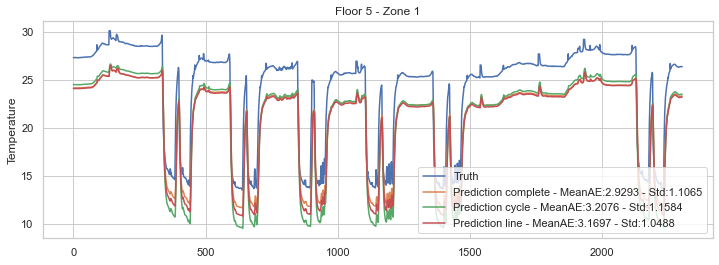

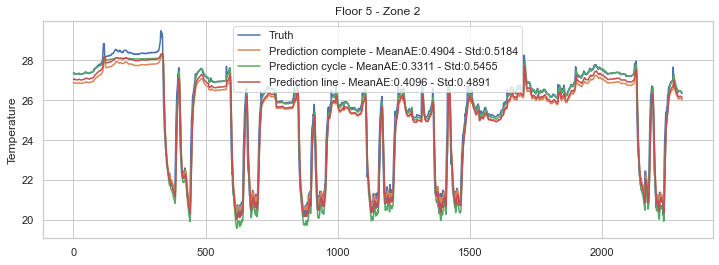

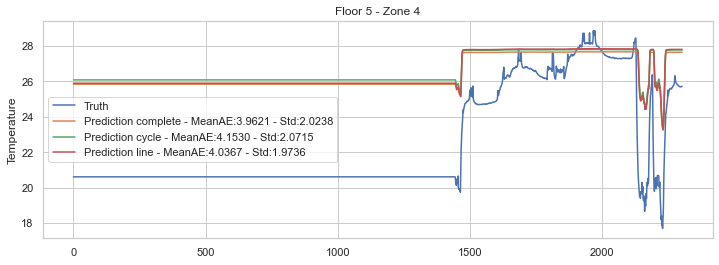

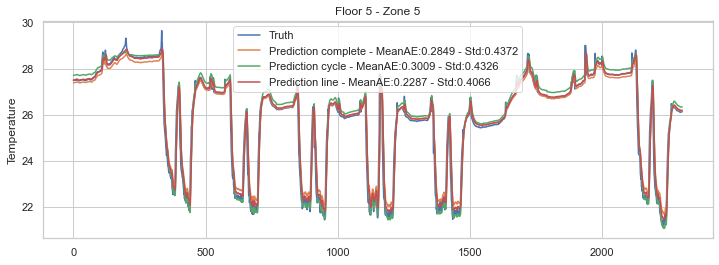

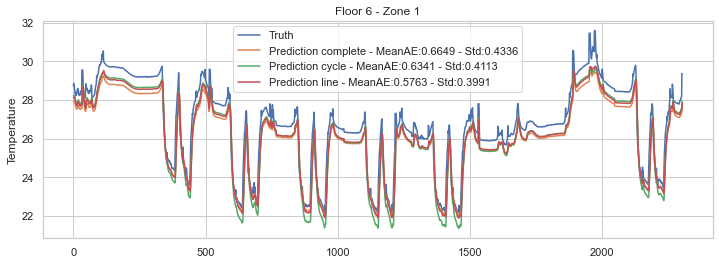

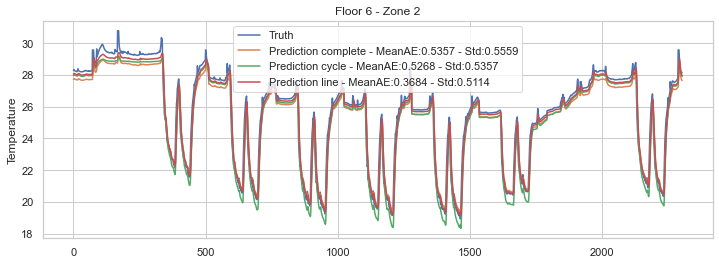

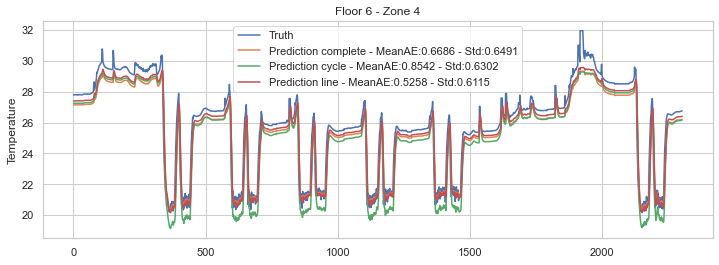

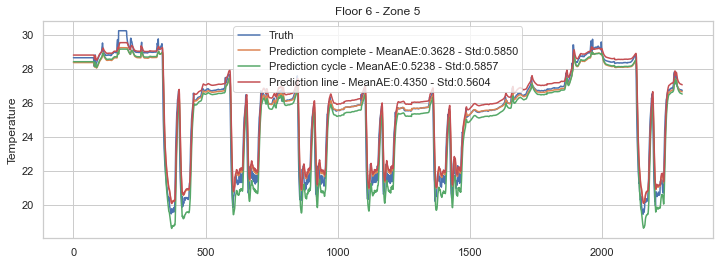

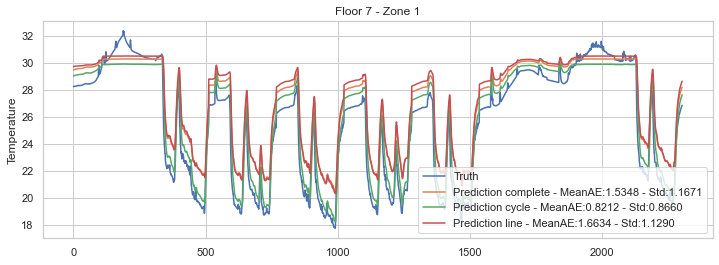

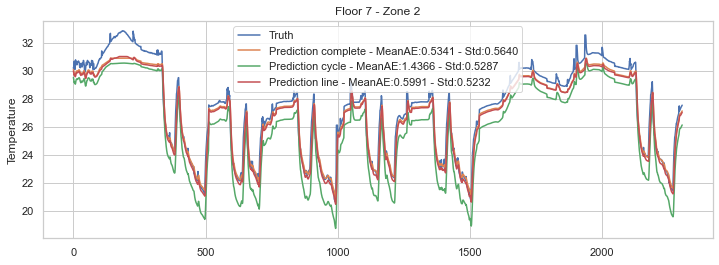

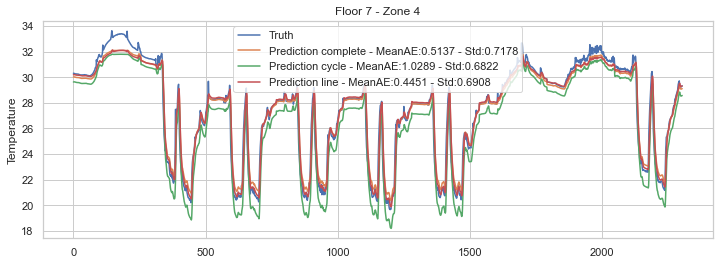

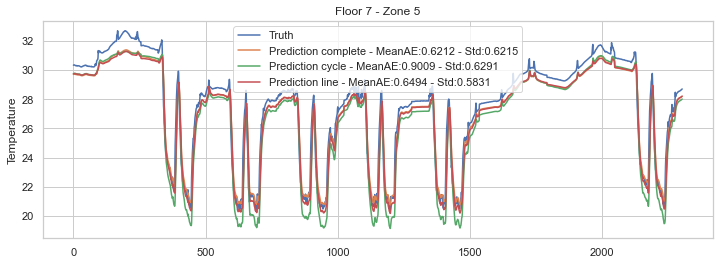

In [356]:
global_path = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/"
accro_path= "567Zone/alpha095-cut20april-hid64-64/"
for floor in [4,5,6,7]:
    for zone in [1,2,4,5]:
        try: plot_compare_prediction(global_path,accro_path, floor, zone, ["complete","cycle","line"], 0,8*nb_timestep)
        except Exception:
            traceback.print_exc()
            pass

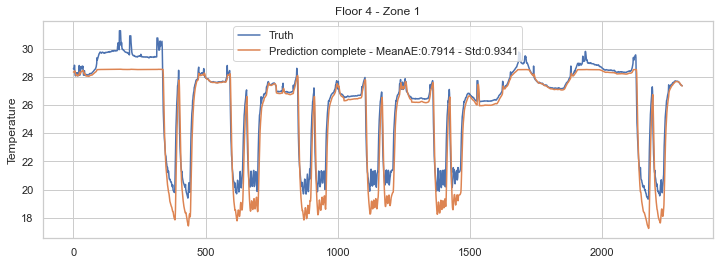

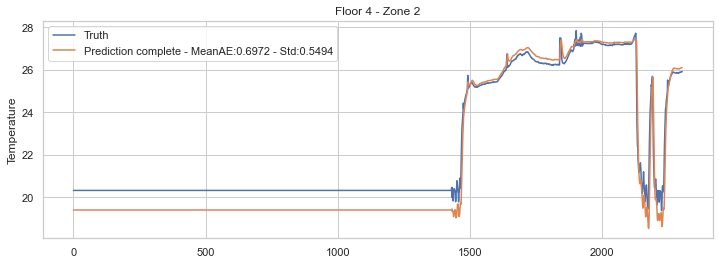

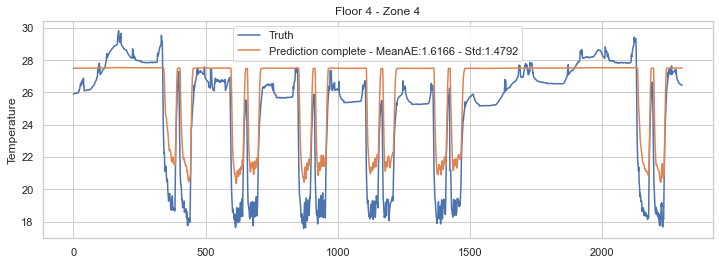

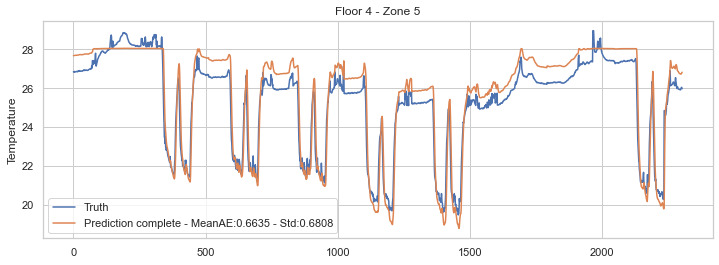

Traceback (most recent call last):
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_1639/1201035743.py", line 5, in <module>
    try:            plot_compare_prediction(global_path,accro_path, floor, zone, ["complete"], 0,8*nb_timestep)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_1639/4200942456.py", line 16, in plot_compare_prediction
    dataframe = compare_prediction_zone(path, accro_path, floor, zone_idx, graph_type)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_1639/4200942456.py", line 10, in compare_prediction_zone
    path_csv = os.path.join(path_graph, zone_pred[0])
IndexError: list index out of range


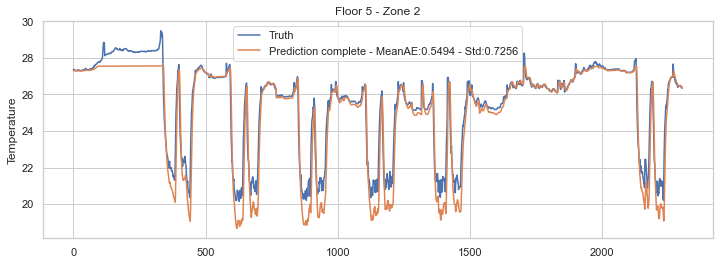

Traceback (most recent call last):
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_1639/1201035743.py", line 5, in <module>
    try:            plot_compare_prediction(global_path,accro_path, floor, zone, ["complete"], 0,8*nb_timestep)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_1639/4200942456.py", line 16, in plot_compare_prediction
    dataframe = compare_prediction_zone(path, accro_path, floor, zone_idx, graph_type)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_1639/4200942456.py", line 10, in compare_prediction_zone
    path_csv = os.path.join(path_graph, zone_pred[0])
IndexError: list index out of range


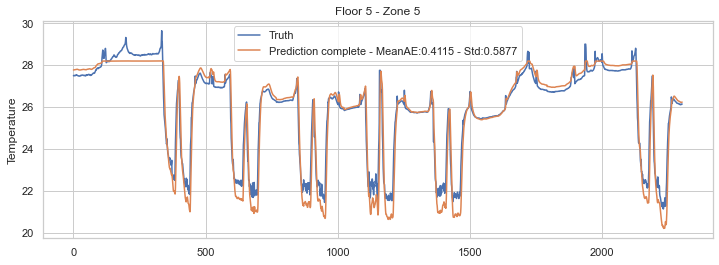

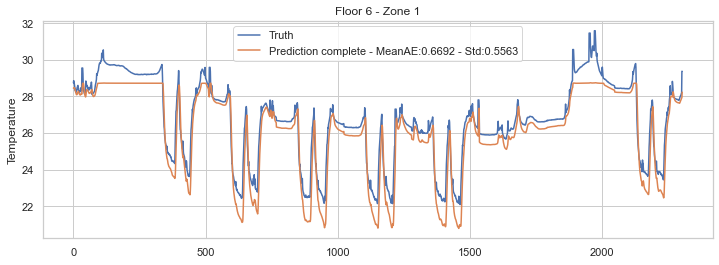

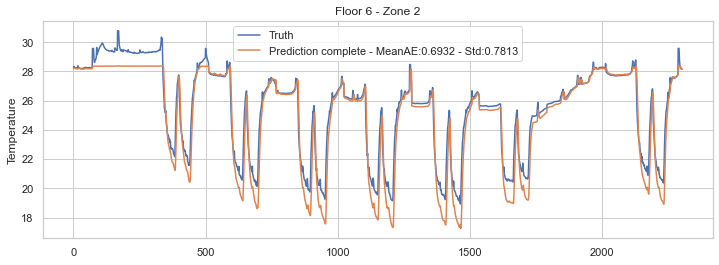

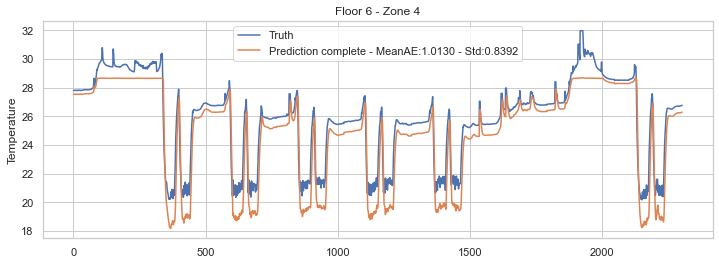

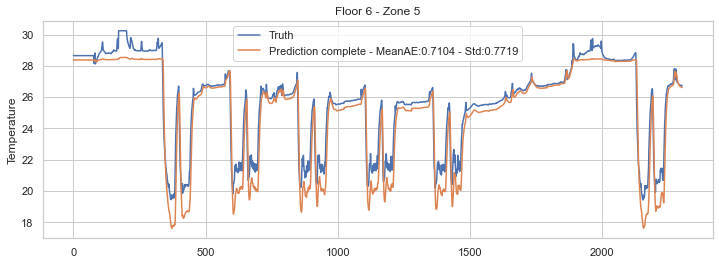

Traceback (most recent call last):
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_1639/1201035743.py", line 5, in <module>
    try:            plot_compare_prediction(global_path,accro_path, floor, zone, ["complete"], 0,8*nb_timestep)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_1639/4200942456.py", line 16, in plot_compare_prediction
    dataframe = compare_prediction_zone(path, accro_path, floor, zone_idx, graph_type)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_1639/4200942456.py", line 10, in compare_prediction_zone
    path_csv = os.path.join(path_graph, zone_pred[0])
IndexError: list index out of range


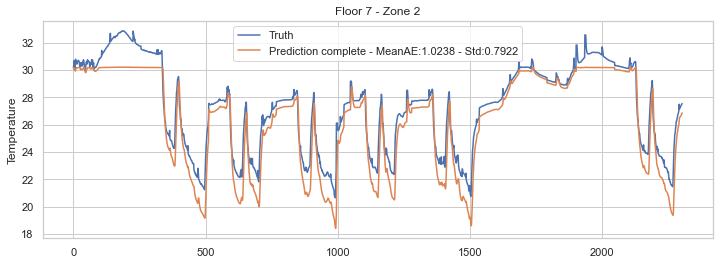

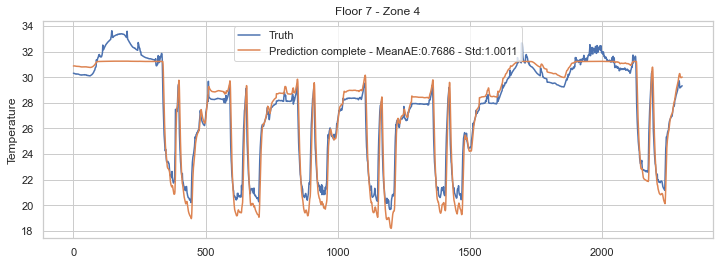

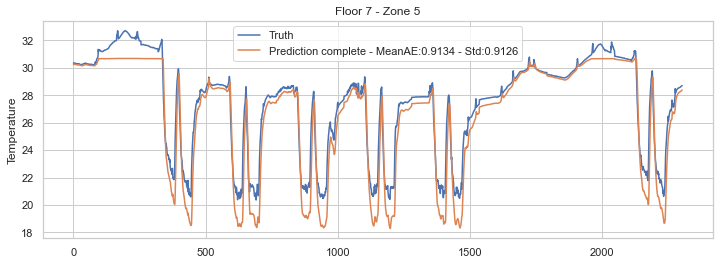

In [357]:
global_path = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/DMFW/"
accro_path= "floor4567/alpha095-cut20april-removed_floors/"
for floor in [4,5,6,7]:
    for zone in [1,2,4,5]:
        try:            plot_compare_prediction(global_path,accro_path, floor, zone, ["complete"], 0,8*nb_timestep)
        except Exception: 
            traceback.print_exc() 
            pass

# Compare 

In [358]:
#path4_avg = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/complete/4Zone/alpha095-cut20april-hid64-64/"
path4 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/MFW/floor4567/alpha095-cut20april-removed_floors/"
path5 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/DMFW/complete/floor4567/alpha095-cut20april-removed_floors/"
#path6 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/DMFW/complete/floor4/alpha095-cut20april-hid64-64-2/"
#path6 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/DMFW/complete/floor6/alpha095-cut20april-hid64-64/"

['prediction-Floor4Z1.csv']


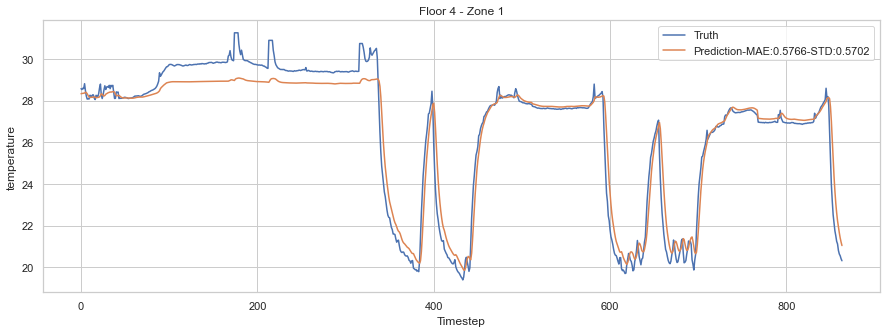

['prediction-Floor4Z1.csv']


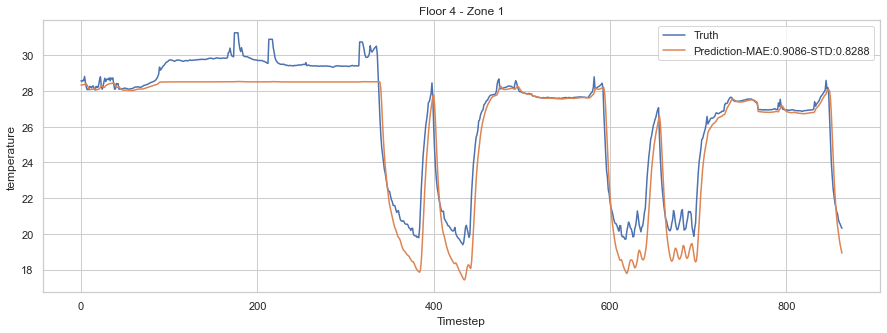

['prediction-Floor4Z2.csv']


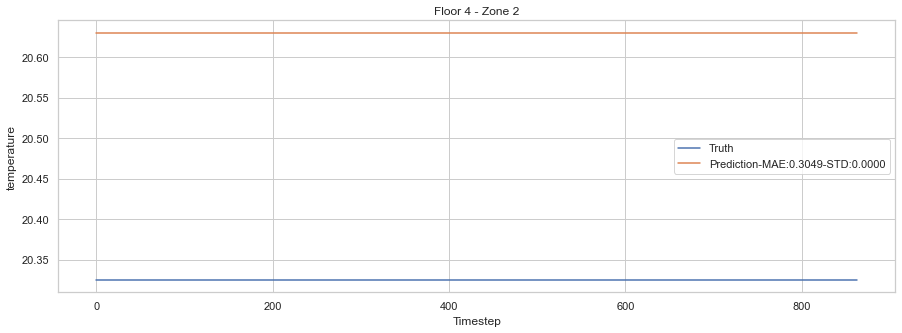

['prediction-Floor4Z2.csv']


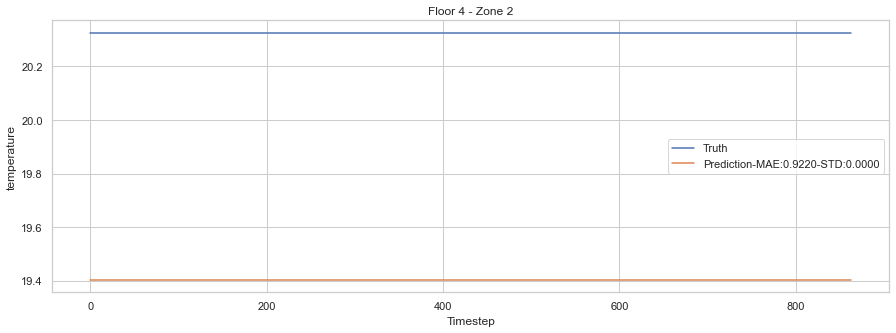

['prediction-Floor4Z4.csv', 'prediction-Floor6Z4.csv', 'prediction-Floor7Z4.csv']


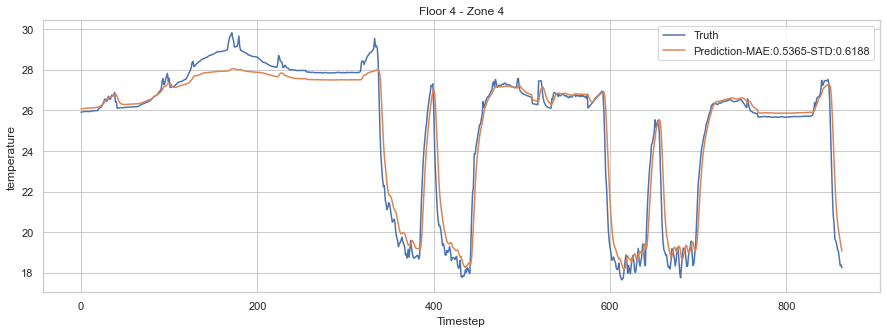

['prediction-Floor4Z4.csv', 'prediction-Floor6Z4.csv', 'prediction-Floor7Z4.csv']


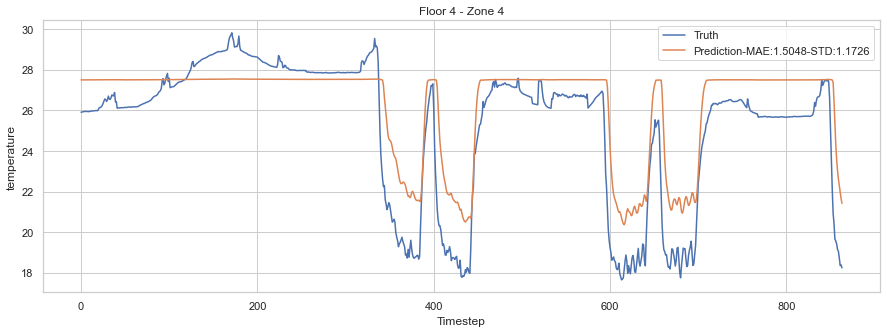

['prediction-Floor4Z5.csv']


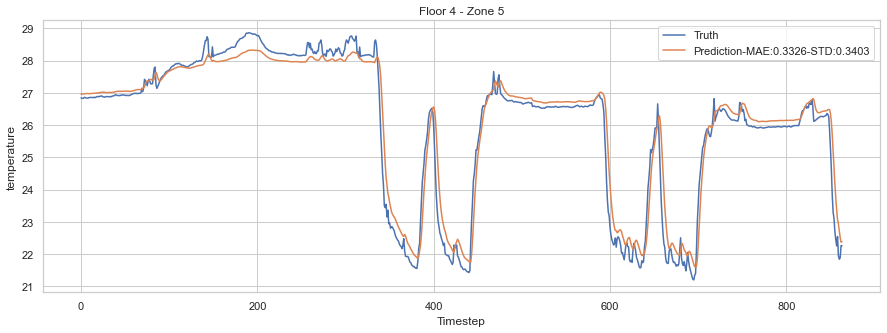

['prediction-Floor4Z5.csv']


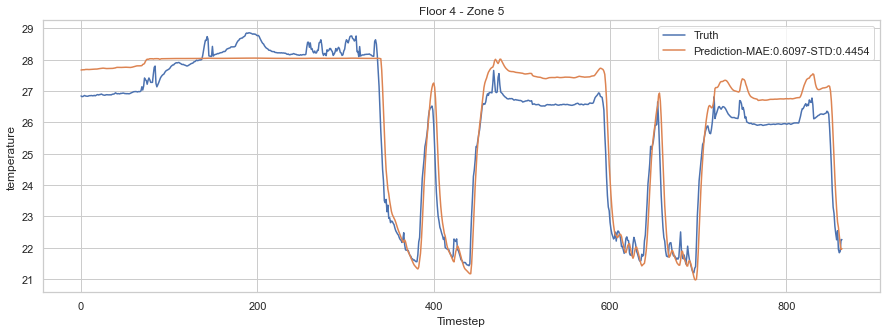

In [359]:
for i in [1,2,4,5]:
    plotPrediction(path4,None,"temperature",str(i),str(4),0, 3*nb_timestep)
    plotPrediction(path5,None,"temperature",str(i),str(4),0, 3*nb_timestep)
    #plotPrediction(path4_normal,None,"temperature",str(i),str(4),0, 3*nb_timestep)

In [464]:
general_path = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/DMFW/complete/"
path6 = general_path + "floor6/alpha095-cut20april-removed_floors/"
path67 = general_path + "floor67/alpha095-cut20april-removed_floors/"
path456 = general_path + "floor456/alpha095-cut20april-removed_floors/"
path4567 = general_path + "floor4567/alpha095-cut20april-removed_floors/"
listpath = [path6, path67, path456, path4567]

In [465]:
def get_multiple_run_byfloor(floor_path):
    init_pd = pd.read_csv(floor_path+"Floor_log.csv",index_col=0, skipfooter=1,engine="python")
    values = init_pd[["Loss","Gap"]]
    for k in [2,3,4,5]:
        path_run = floor_path[:-1]+f"-{k}/"
        pd_file = pd.read_csv(path_run+"Floor_log.csv",index_col=0,skipfooter=1,engine="python")
        values = pd.concat([values, pd_file["Loss"].rename(f"Loss{k}"), pd_file["Gap"].rename(f"Gap{k}")],axis=1)

    return values
def get_average_run_byfloor(floor_run):
    col_loss = [col for col in floor_run.columns if col.startswith("Loss")]
    col_gap = [col for col in floor_run.columns if col.startswith("Gap")]
    res = pd.DataFrame()
    res["avgrun_Loss"] = floor_run[col_loss].mean(axis=1)
    res["avgrun_Gap"] = floor_run[col_gap].mean(axis=1)
    res["avgT_Loss"] = average_loss(res["avgrun_Loss"])
    return res

In [466]:
floor6run = get_multiple_run_byfloor(path6)
floor67run = get_multiple_run_byfloor(path67)
floor456run = get_multiple_run_byfloor(path456)
floor4567run = get_multiple_run_byfloor(path4567)

avgfloor6 = get_average_run_byfloor(floor6run)
avgfloor67 = get_average_run_byfloor(floor67run)
avgfloor456 = get_average_run_byfloor(floor456run)
avgfloor4567 = get_average_run_byfloor(floor4567run)

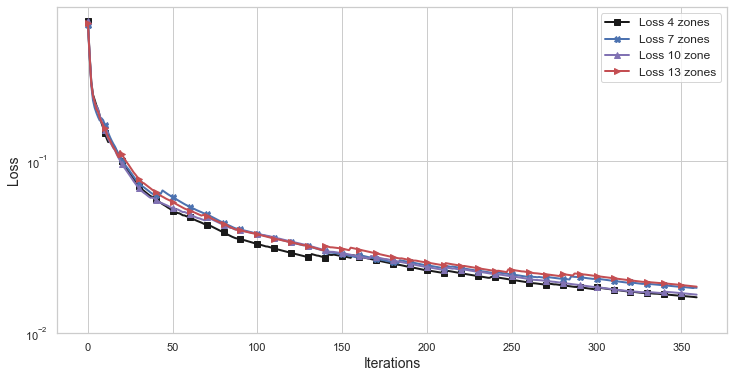

In [473]:
#plt.figure(figsize=(12,6))
fig,ax = plt.subplots(figsize=(12,6))
#logfig = pd.DataFrame()
#ax2=ax.twinx()
name = ["4 zones","7 zones","10 zone","13 zones"]
resfloors = [avgfloor6,avgfloor67,avgfloor456,avgfloor4567]
colors = ["k","b","m","r",]
#colors = ["b","g","r","c","m","y","k","w"]
markers = ["s","X","^",">"]
for i,res,m,c in zip(name,resfloors,markers,colors):
    #datalogs = pd.read_csv(path+"Floor_log.csv",index_col=0,skipfooter=1,engine="python")
    #logfig = pd.concat([logfig, datalogs["Gap"].rename(f"Gap_{i}")],axis=1)
    ax.plot(res["avgT_Loss"],label=f"Loss {i}",linewidth=2, color=c,
            marker=m, markersize=6,markevery=[i for i in range(logfig.shape[0]) if i%10==0])
    #ax2.plot(res["avgrun_Gap"],label=f"Gap {i}",linewidth=2, color=c,ls="-.",
    #        marker=m, markersize=6,markevery=[i for i in range(logfig.shape[0]) if i%10==0])
    ax.set_yscale("log")
    #ax2.set_yscale("log")
    ax.set_ylim(bottom=10**-2)
    #ax2.set_ylim(bottom=10**-1)
    ax.set_ylabel("Loss",fontsize=14)
    #ax2.set_ylabel("Gap",fontsize=14)
    ax.set_xlabel("Iterations",fontsize=14)
fig.legend(loc="upper right",bbox_to_anchor=(1,1),bbox_transform=ax.transAxes,prop={"size":12})
#plt.legend(prop={'size':14})

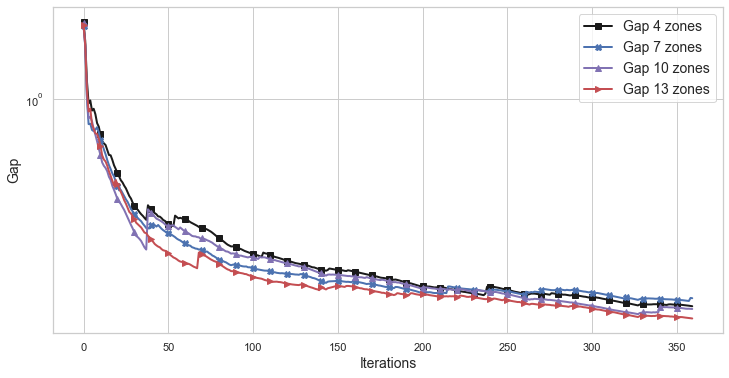

In [474]:
plt.figure(figsize=(12,6))
#logfig = pd.DataFrame()
name = ["4 zones","7 zones","10 zones","13 zones"]
resfloors = [avgfloor6,avgfloor67,avgfloor456,avgfloor4567]
colors = ["k","b","m","r"]
markers = ["s","X","^",">"]
for i,res,m,c in zip(name,resfloors,markers,colors):
    #datalogs = pd.read_csv(path+"Floor_log.csv",index_col=0,skipfooter=1,engine="python")
    #logfig = pd.concat([logfig, datalogs["Gap"].rename(f"Gap_{i}")],axis=1)
    plt.plot(res["avgrun_Gap"],label=f"Gap {i}",linewidth=2, color=c,
            marker=m, markersize=6,markevery=[i for i in range(logfig.shape[0]) if i%10==0])
    plt.yscale("log")
    #plt.ylim(bottom=10**-1)
    plt.ylabel("Gap",fontsize=14)
    plt.xlabel("Iterations",fontsize=14)
    plt.legend(prop={'size':14})

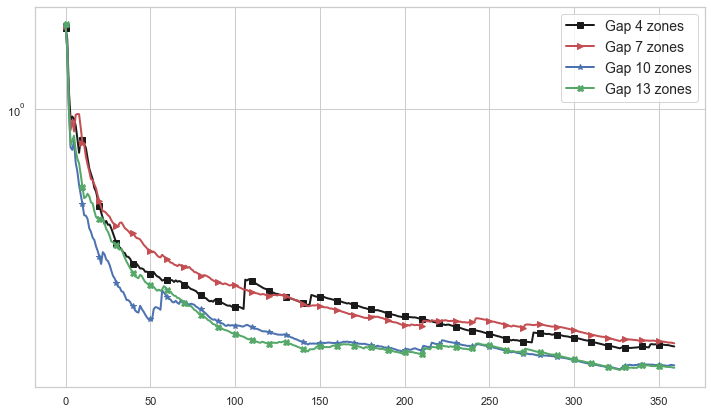

In [407]:
plt.figure(figsize=(12,7))
logfig = pd.DataFrame()
name = ["4 zones", "7 zones", "10 zones", "13 zones"]
colors = ["k","r","b","g"]
markers = ["s",">","*","X"]
for i,path,m,c in zip(name,listpath,markers,colors):
    datalogs = pd.read_csv(path+"Floor_log.csv",index_col=0,skipfooter=1,engine="python")
    logfig = pd.concat([logfig, datalogs["Gap"].rename(f"Gap_{i}")],axis=1)
    plt.plot(logfig[f"Gap_{i}"],label=f"Gap {i}",linewidth=2, color=c,
            marker=m, markersize=6,markevery=[i for i in range(logfig.shape[0]) if i%10==0])
    plt.yscale("log")
    plt.legend(prop={'size':14})

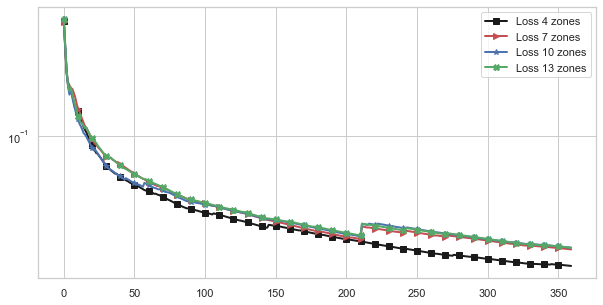

In [365]:
plt.figure(figsize=(10,5))
logfig = pd.DataFrame()
name = ["4 zones", "7 zones", "10 zones", "13 zones"]
colors = ["k","r","b","g"]
markers = ["s",">","*","X"]
for i,path,m,c in zip(name,listpath,markers,colors):
    datalogs = pd.read_csv(path+"Floor_log.csv",index_col=0,skipfooter=1,engine="python")
    logfig = pd.concat([logfig, datalogs["Loss"].rename(f"Loss_{i}")],axis=1)
    plt.plot(average_loss(logfig[f"Loss_{i}"]),label=f"Loss {i}",linewidth=2,color=c,
            marker=m, markersize=6,markevery=[i for i in range(logfig.shape[0]) if i%10==0])
    plt.yscale("log")
    plt.legend()

In [366]:
logfig

,Loss_4 zones,Loss_7 zones,Loss_10 zones,Loss_13 zones
0,0.617038,0.609651,0.635258,0.639604
1,0.177028,0.199747,0.193771,0.196909
2,0.016295,0.016400,0.013522,0.013437
3,0.089508,0.113008,0.031215,0.043383
4,0.148154,0.182069,0.090249,0.126645
...,...,...,...,...
355,0.007696,0.000647,0.000699,0.002004
356,0.000222,0.003042,0.009053,0.002809
357,0.000427,0.004359,0.011325,0.002324
358,0.000221,0.000380,0.000696,0.000441


FileNotFoundError: [Errno 2] No such file or directory: '/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/DMFW/complete/floor6/alpha095-cut20april-hid64-64/Floor_log.csv'

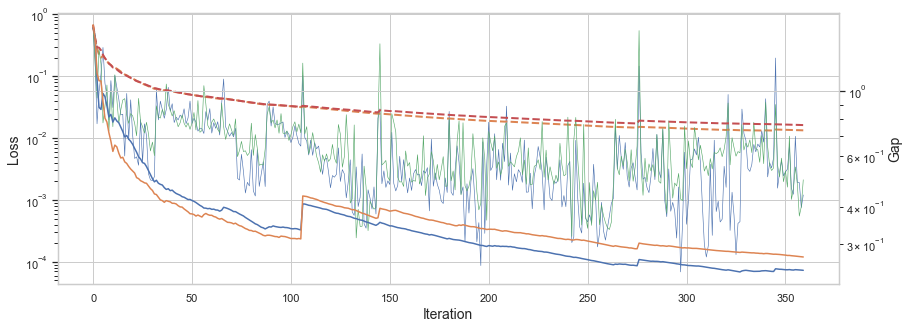

In [367]:
fig,ax = plt.subplots(figsize=(14,5))
logs_floors = pd.DataFrame()
ax2=ax.twinx()
for floor in [4,5,6]:
    path = f"/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/DMFW/complete/floor{floor}/alpha095-cut20april-hid64-64/"
    #path_mfw = f"/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/MFW/floor{floor}/alpha095-cut20april-hid64-64/"
    logs = pd.read_csv(path+"Floor_log.csv",index_col=0)[:-1]
    logs = logs.rename(columns={"Loss": f"Loss{floor}","Gap":f"Gap{floor}"})
    #logs["Gap"].rename(f"Gap {floor}")
    logs_floors = pd.concat([logs_floors, logs],axis=1)
    ax.plot(logs_floors[f"Loss{floor}"],label=f"Step Loss {floor}",linewidth=0.6)
    ax.plot(average_loss(logs_floors[f"Loss{floor}"]),ls='--',linewidth=2,label=f"Average Loss Floor {floor}")
    # set x-axis label
    ax.set_xlabel("Iteration",fontsize=14)
    # set y-axis label
    ax.set_ylabel("Loss",fontsize=14)
    ax.set_yscale("log")
    ax2.plot(logs_floors[f"Gap{floor}"],label=f"Gap Floor {floor}")
    ax2.set_ylabel("Gap",fontsize=14)
    ax2.set_yscale("log")
fig.legend(loc="upper right",bbox_to_anchor=(1,1),bbox_transform=ax.transAxes)
plt.show()

# Compare MFW

In [420]:
path_dmfw = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/DMFW/complete/floor4567/alpha095-cut20april-removed_floors/"
path_mfw = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/MFW/floor4567/alpha095-cut20april-removed_floors/"
path_smfw = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/SMFW/floor4567/alpha095-cut20april-removed_floors/"

In [421]:
def get_multiple_run(path_dmfw, path_mfw,path_smfw):
    init_dmfw = pd.read_csv(path_dmfw+"Floor_log.csv",index_col=0,skipfooter=1,engine="python")
    init_mfw = pd.read_csv(path_mfw+"Floor_log.csv",index_col=0)
    init_smfw = pd.read_csv(path_smfw+"Floor_log.csv",index_col=0)
    
    loss_dmfw = init_dmfw[["Loss","Gap"]]
    loss_mfw = init_mfw[["Loss","Gap"]]
    loss_smfw = init_smfw[["Loss","Gap"]]
    #print(loss_dmfw)
    
    for k in [2,3,4,5]:
        path_dmfw_k = path_dmfw[:-1]+f"-{k}/"
        path_mfw_k = path_mfw[:-1]+f"-{k}/"
        path_smfw_k = path_smfw[:-1]+f"-{k}/"
        dmfw_k = pd.read_csv(path_dmfw_k+"Floor_log.csv", index_col=0,skipfooter=1,engine="python")
        mfw_k = pd.read_csv(path_mfw_k+"Floor_log.csv", index_col=0)
        smfw_k = pd.read_csv(path_smfw_k+"Floor_log.csv", index_col=0)
        
        loss_dmfw = pd.concat([loss_dmfw, dmfw_k["Loss"].rename(f"Loss{k}"), dmfw_k["Gap"].rename(f"Gap{k}")], axis=1)
        loss_mfw = pd.concat([loss_mfw, mfw_k["Loss"].rename(f"Loss{k}"), mfw_k["Gap"].rename(f"Gap{k}")],axis=1)
        loss_smfw = pd.concat([loss_smfw, smfw_k["Loss"].rename(f"Loss{k}"), smfw_k["Gap"].rename(f"Gap{k}")],axis=1)
        
    return loss_dmfw, loss_mfw, loss_smfw

def get_average_run(pd_dmfw, pd_mfw, pd_smfw):
    col_loss = [col for col in pd_dmfw.columns if col.startswith("Loss")]
    col_gap = [col for col in pd_dmfw.columns if col.startswith("Gap")]
    
    result = pd.DataFrame()
    for name,data in zip(["dmfw","mfw","smfw"],[pd_dmfw, pd_mfw, pd_smfw]):
        result[f"avgrun_Loss-{name}"] = data[col_loss].mean(axis=1)
        #result[f"stdrun_Loss-{name}"] = data[col_loss].std(axis=1)
        result[f"avgrun_Gap-{name}"] = data[col_gap].mean(axis=1)
        #result[f"stdrun_Gap-{name}"] = data[col_gap].std(axis=1)
        
        result[f"avgT_Loss-{name}"] = average_loss(result[f"avgrun_Loss-{name}"])
        #result[f"lowT_Loss-{name}"] = average_loss(result[f"avgrun_Loss-{name}"]) - average_loss(result[f"stdrun_Loss-{name}"])
        #result[f"upT_Loss-{name}"] = average_loss(result[f"avgrun_Loss-{name}"]) + average_loss(result[f"stdrun_Loss-{name}"])
        
        #result[f"lowT_Gap-{name}"] = result[f"avgrun_Gap-{name}"] - result[f"stdrun_Gap-{name}"]
        #result[f"upT_Gap-{name}"] = result[f"avgrun_Gap-{name}"] + result[f"stdrun_Gap-{name}"]
    
    return result
    

In [422]:
dmfw, mfw, smfw = get_multiple_run(path_dmfw, path_mfw, path_smfw)
res = get_average_run(dmfw, mfw, smfw)

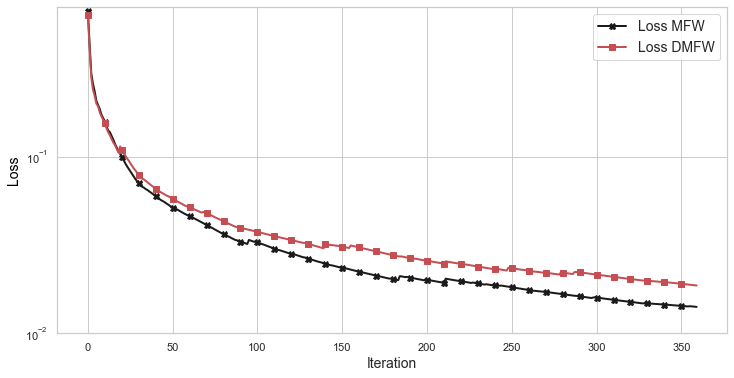

In [423]:
fig,ax = plt.subplots(figsize=(12,6))
#ax2=ax.twinx()
#ax.plot(logs.Iteration, logs.Loss,label="Step Loss 13 Nodes")
ax.plot(res["avgT_Loss-mfw"],ls="-",linewidth=2,label="Loss MFW",
        marker='X', markersize=6,markevery=[i for i in range(res.shape[0]) if i%10==0], color="k")
#ax.plot(res["avgrun_Loss-dmfw"],label="Step Loss DMFW",linewidth=0.6)
#ax.fill_between(np.arange(res.shape[0]), res["lowT_Loss-mfw"], res["upT_Loss-mfw"],alpha=0.1,facecolor='#089FFF')
#ax.plot(res["avgT_Loss-smfw"],ls="-",linewidth=2,label="Average Loss SMFW",
#        marker='^', markersize=6,markevery=[i for i in range(res.shape[0]) if i%10==0])
#ax.plot(res["avgrun_Loss-mfw"],label="Step Loss DMFW",linewidth=0.6)
#ax.fill_between(np.arange(res.shape[0]), res["lowT_Loss-smfw"], res["upT_Loss-smfw"],alpha=0.1,facecolor='#FE9A39')
ax.plot(res["avgT_Loss-dmfw"],ls="-",linewidth=2,label="Loss DMFW",
        marker='s', markersize=6,markevery=[i for i in range(res.shape[0]) if i%10==0], color="r")
#ax.plot(res["avgrun_Loss-smfw"],label="Step Loss SMFW",linewidth=0.6)
#ax.fill_between(np.arange(res.shape[0]), res["lowT_Loss-dmfw"], res["upT_Loss-dmfw"],alpha=0.1,facecolor='#39FE73')
#ax.plot(res["avgrun_Loss-dmfw"],label="Step Loss DMFW",linewidth=0.6)
#ax.plot(res["avgrun_Loss-mfw"],label="Step Loss MFW",linewidth=0.6)


#ax.plot(dmfw.Iteration, logs.Loss,label="Step Loss DMFW",linewidth=0.6)
#ax.plot(logs_ofw.Iteration, logs_ofw.Loss,label="Step Loss MFW",linewidth=0.6)
# set x-axis label
ax.set_xlabel("Iteration",fontsize=14)
# set y-axis label
ax.set_ylabel("Loss",color="black",fontsize=14)
ax.set_ylim(bottom=10**-2)
ax.set_yscale("log")

#ax2.hlines(y=1.4, xmin=0, xmax=res.shape[0], color="grey",ls="--")
#ax2.plot(res["avgT_Loss-dmfw"]/res["avgT_Loss-mfw"],label="Ratio DMFW/MFW",linewidth=2,ls="--",
#         marker='>', markersize=6,markevery=[i for i in range(res.shape[0]) if i%10==0],color="b")
#ax2.set_ylabel("A(Iteration)",fontsize=14)
#ax2.plot(res["avgrun_Gap-dmfw"],label="Gap DMFW",#linewidth=1,
#         marker='^', markersize=4,markevery=[i for i in range(res.shape[0]) if i%10==0])
#ax2.fill_between(np.arange(res.shape[0]), res["lowT_Gap-dmfw"], res["upT_Gap-dmfw"],alpha=0.2,facecolor='#089FFF')
#ax2.plot(res["avgrun_Gap-mfw"],label="Gap MFW",#linewidth=2,
#         marker='^', markersize=4,markevery=[i for i in range(res.shape[0]) if i%10==0])
#ax2.fill_between(np.arange(res.shape[0]), res["lowT_Gap-mfw"], res["upT_Gap-mfw"],alpha=0.2,facecolor='#FE9A39')
#ax2.plot(res["avgrun_Gap-smfw"],label="Gap SMFW",#linewidth=2,
#         marker='^', markersize=4,markevery=[i for i in range(res.shape[0]) if i%10==0])
#ax2.fill_between(np.arange(res.shape[0]), res["lowT_Gap-smfw"], res["upT_Gap-smfw"],alpha=0.2,facecolor='#39FE73')
#ax2.plot(logs.Iteration, logs["Local Gap"],label="Local Gap DMFW",linewidth=0.6)
#ax2.plot(logs.Iteration, logs_ofw["Local Gap"],label="Local Gap MFW",linewidth=0.6)
         #marker='^', markersize=4,markevery=[i for i in range(logs.shape[0]) if i%10==0])
#ax2.set_ylabel("Gap",fontsize=14)
#ax2.set_yscale("log")
fig.legend(loc="upper right",bbox_to_anchor=(1,1),bbox_transform=ax.transAxes,prop={'size':14})
plt.show()

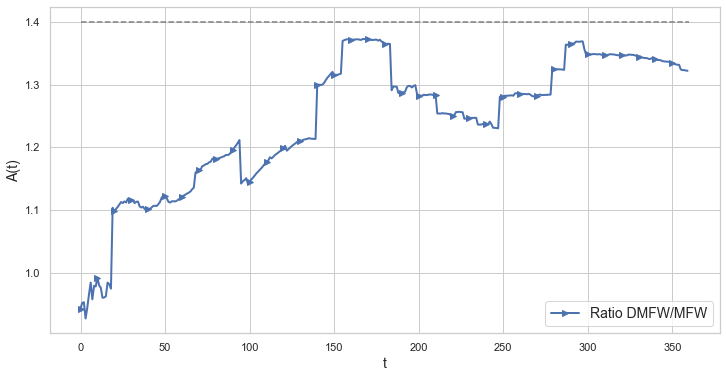

In [424]:
plt.figure(figsize=(12,6))
plt.plot(res["avgT_Loss-dmfw"]/res["avgT_Loss-mfw"],label="Ratio DMFW/MFW",linewidth=2,
         marker='>', markersize=6,markevery=[i for i in range(res.shape[0]) if i%10==0],color="b")
#plt.plot(logs_ofw["Gap"]/logs["Gap"],label="Gap Ratio")
plt.hlines(y=1.4, xmin=0, xmax=res.shape[0], color="grey",ls="--")
plt.xlabel("t",fontsize=14)
plt.ylabel("A(t)",fontsize=14)
plt.legend(loc="lower right",prop={"size":14})

In [146]:
logs = pd.read_csv(path_new+"Floor_log.csv",index_col=0)[:-1]
logs_ofw = pd.read_csv(path_ofw+"Floor_log.csv",index_col=0)

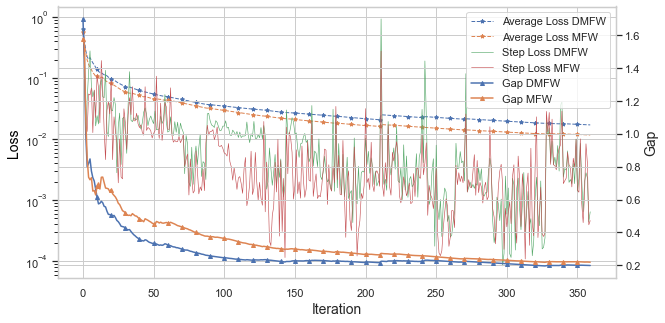

In [147]:
fig,ax = plt.subplots(figsize=(10,5))
ax2=ax.twinx()
#ax.plot(logs.Iteration, logs.Loss,label="Step Loss 13 Nodes")
ax.plot(average_loss(logs.Loss),ls="--",linewidth=1,label="Average Loss DMFW",
        marker='*', markersize=4,markevery=[i for i in range(logs.shape[0]) if i%10==0])
ax.plot(average_loss(logs_ofw.Loss),ls="--",linewidth=1,label="Average Loss MFW",
       marker='*', markersize=4,markevery=[i for i in range(logs.shape[0]) if i%10==0])
#ax.plot(average_loss(logs_ofw["Loss"])/average_loss(logs["Loss"]))
ax.plot(logs.Iteration, logs.Loss,label="Step Loss DMFW",linewidth=0.6)
ax.plot(logs_ofw.Iteration, logs_ofw.Loss,label="Step Loss MFW",linewidth=0.6)
# set x-axis label
ax.set_xlabel("Iteration",fontsize=14)
# set y-axis label
ax.set_ylabel("Loss",color="black",fontsize=14)
ax.set_yscale("log")

ax2.plot(logs.Iteration, logs.Gap,label="Gap DMFW",#linewidth=1,
         marker='^', markersize=4,markevery=[i for i in range(logs.shape[0]) if i%10==0])
ax2.plot(logs.Iteration, logs_ofw.Gap,label="Gap MFW",#linewidth=2,
         marker='^', markersize=4,markevery=[i for i in range(logs.shape[0]) if i%10==0])
#ax2.plot(logs.Iteration, logs["Local Gap"],label="Local Gap DMFW",linewidth=0.6)
#ax2.plot(logs.Iteration, logs_ofw["Local Gap"],label="Local Gap MFW",linewidth=0.6)
         #marker='^', markersize=4,markevery=[i for i in range(logs.shape[0]) if i%10==0])
ax2.set_ylabel("Gap",fontsize=14)
#ax2.set_yscale("log")
fig.legend(loc="upper right",bbox_to_anchor=(1,1),bbox_transform=ax.transAxes)
plt.show()
# save the plot as a file

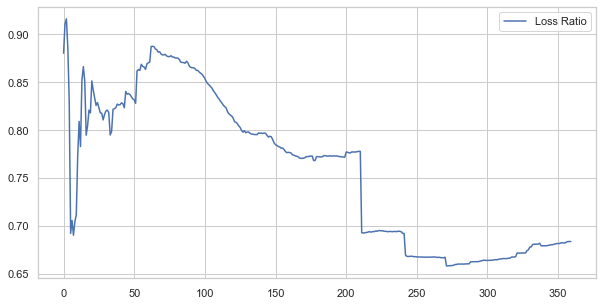

In [149]:
plt.figure(figsize=(10,5))
plt.plot(average_loss(logs_ofw["Loss"])/average_loss(logs["Loss"]),label="Loss Ratio")
#plt.plot(logs_ofw["Gap"]/logs["Gap"],label="Gap Ratio")
plt.legend()

In [27]:
logs

,Iteration,Loss,Gap,Local Gap
0,0.0,0.639604,1.698910,1.698910
1,1.0,0.196909,1.464205,1.229511
2,2.0,0.013437,0.996662,0.061590
3,3.0,0.043383,0.799580,0.208362
4,4.0,0.126645,0.820336,0.903723
...,...,...,...,...
356,356.0,0.002809,0.200104,0.166313
357,357.0,0.002324,0.199895,0.129847
358,358.0,0.000441,0.199472,0.054717
359,359.0,0.000645,0.199081,0.061509
